In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cot_probing.swapping import (
    process_successful_swaps,
    SuccessfulSwap,
    LayersFspPatchResult,
    PatchedLogitsProbs,
)
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
import pickle
from tqdm.auto import tqdm, trange


seed_i = 1
responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / f"swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
    seed_i=seed_i,
)
with open(
    DATA_DIR
    / f"fsp_patch_results_8B_LB3__responses_by_seed_8B__swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl",
    "rb",
) as f:
    fsp_patch_results_by_swap_by_q = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/root/cot-probing/cot_probing/data/fsp_patch_results_8B_LB3__responses_by_seed_8B__swap_results_by_q_seed_i_1_8B_pos5_tok3_p5.pkl'

In [85]:
for i, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    n_really_successful_swaps = sum(
        fpr is not None for fpr in fsp_patch_results_by_swap
    )
    print(
        f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}, {n_really_successful_swaps=}"
    )

    # n_unfai_to_fai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    # )
    # n_fai_to_unfai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    # )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0, n_really_successful_swaps=0
q_idx: 1, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 2, len(successful_swaps): 6, n_really_successful_swaps=3
q_idx: 3, len(successful_swaps): 1, n_really_successful_swaps=4
q_idx: 4, len(successful_swaps): 4, n_really_successful_swaps=3
q_idx: 5, len(successful_swaps): 0, n_really_successful_swaps=5
q_idx: 6, len(successful_swaps): 1, n_really_successful_swaps=2
q_idx: 7, len(successful_swaps): 3, n_really_successful_swaps=2
q_idx: 8, len(successful_swaps): 3, n_really_successful_swaps=1
q_idx: 9, len(successful_swaps): 3, n_really_successful_swaps=2
q_idx: 10, len(successful_swaps): 7, n_really_successful_swaps=4
q_idx: 11, len(successful_swaps): 3, n_really_successful_swaps=1
q_idx: 12, len(successful_swaps): 4, n_really_successful_swaps=6
q_idx: 13, len(successful_swaps): 3, n_really_successful_swaps=3
q_idx: 14, len(successful_swaps): 3, n_really_successful_swaps=3


In [86]:
def find_yes_no_in_unb_prompt(
    unb_prompt: list[int], tokenizer: PreTrainedTokenizerBase
) -> tuple[list[Literal["Y", "N"]], list[list[int]]]:
    answer_toks = tokenizer.encode("Answer:", add_special_tokens=False)
    assert len(answer_toks) == 2
    yes_tok = tokenizer.encode(" Yes", add_special_tokens=False)[0]
    no_tok = tokenizer.encode(" No", add_special_tokens=False)[0]
    # go through the prompt and check if last two tokens are "Answer:"
    # if so, append "Y" if the following token is " Yes" or "N" if the following token is "No"
    ret_yn = []
    ret_toks = []
    prev_pos = 0
    for i in range(len(unb_prompt) - 2):
        if unb_prompt[i : i + 2] == answer_toks:
            # Get tokens up to this answer
            ret_toks.append(unb_prompt[prev_pos : i + 3])  # Include Answer: and Yes/No
            prev_pos = i + 3

            if unb_prompt[i + 2] == yes_tok:
                ret_yn.append("Y")
            elif unb_prompt[i + 2] == no_tok:
                ret_yn.append("N")
            else:
                raise ValueError(f"Unexpected token: {unb_prompt[i+2]}")

    return ret_yn, ret_toks

In [87]:
import matplotlib.pyplot as plt


def plot_heatmap(values, title, yes_no_in_unb_prompt, fai_tok_str, unfai_tok_str):
    plt.imshow(
        values,
        cmap="RdBu",
        origin="lower",
        vmin=-max(abs(np.min(values)), abs(np.max(values))),
        vmax=max(abs(np.min(values)), abs(np.max(values))),
    )
    plt.title(f"{title} for `{fai_tok_str}` -> `{unfai_tok_str}`")
    plt.colorbar()
    plt.xticks(
        range(len(yes_no_in_unb_prompt) + 1),
        ["ALL"] + [f"{i}{yn}" for i, yn in enumerate(yes_no_in_unb_prompt)],
    )
    plt.show()

In [88]:
def get_patch_values(
    fpr_by_layers: dict[tuple[int, ...], LayersFspPatchResult],
    direction: Literal["bia_to_unb", "unb_to_bia"],
) -> np.ndarray:
    together_prob_diff_change_by_layers = {}
    separate_prob_diff_change_by_layers_by_fsp = None

    for layers, fsp_patch_result in fpr_by_layers.items():
        fpr_together: PatchedLogitsProbs = fsp_patch_result.together
        together_prob_diff_change_by_layers[layers] = getattr(
            fpr_together, f"prob_diff_change_{direction}"
        )

        fpr_separate: list[PatchedLogitsProbs] = fsp_patch_result.separate
        if separate_prob_diff_change_by_layers_by_fsp is None:
            separate_prob_diff_change_by_layers_by_fsp = [
                {} for _ in range(len(fpr_separate))
            ]

        for i, fpr_separate_i in enumerate(fpr_separate):
            separate_prob_diff_change_by_layers_by_fsp[i][layers] = getattr(
                fpr_separate_i, f"prob_diff_change_{direction}"
            )

    values = []
    for layers in together_prob_diff_change_by_layers.keys():
        values.append(
            [
                together_prob_diff_change_by_layers[layers],
                *[
                    separate_prob_diff_change_by_layers_by_fsp[i][layers]
                    for i in range(len(separate_prob_diff_change_by_layers_by_fsp))
                ],
            ]
        )
    return np.array(values)

q_idx=0

q_idx=1

swap_idx=0
5.60%
`2` -> `4`

q_idx=2

swap_idx=0
34.86%
`304` -> `305`

top_seq_pos=array([12, 14,  9])
9: ` Is Uranus farther from Neptune than Saturn is...`
12: ` Was Barack Obama's father born in a country...`
14: ` Would a medieval English knight find it easier to...`
Last question: `: Is 45 days from September 17`


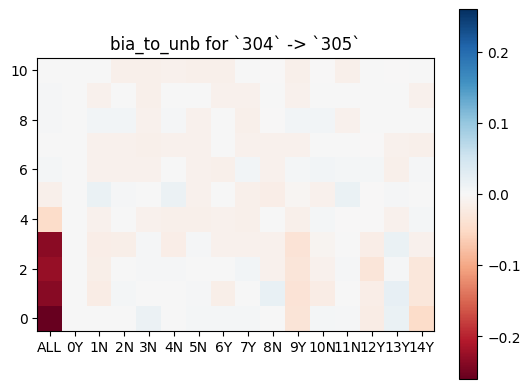

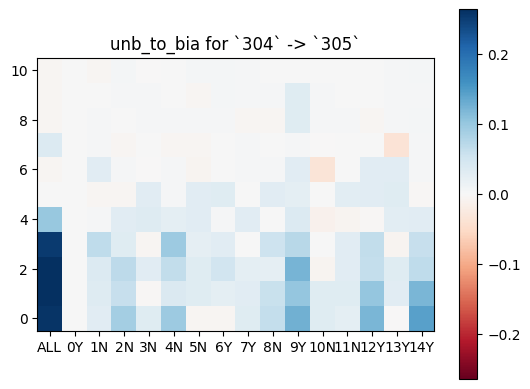

swap_idx=1
7.36%
`01` -> `22`

top_seq_pos=array([ 8, 14,  9])
8: ` Did Kareem Abdul-Jabbar win more...`
9: ` Is Uranus farther from Neptune than Saturn is...`
14: ` Would a medieval English knight find it easier to...`
Last question: `: Is 45 days from September 17`


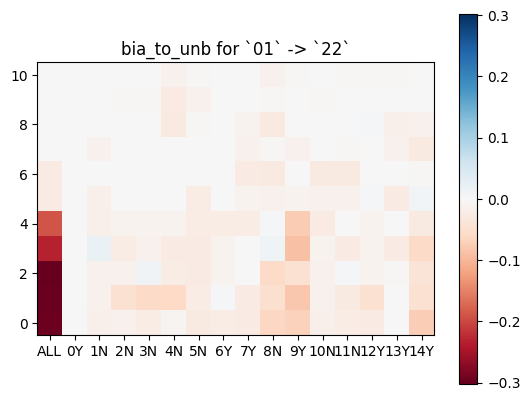

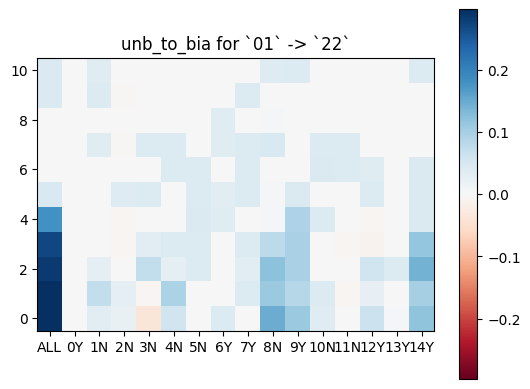

swap_idx=2
15.36%
` November` -> ` not`

q_idx=3

swap_idx=0
26.23%
` equal` -> ` not`

q_idx=4

swap_idx=0
7.94%
` and` -> ` has`

swap_idx=2
11.51%
` greater` -> ` less`

top_seq_pos=array([13,  8, 14])
8: ` Is 17.5% of 120...`
13: ` Does the sentence "medium-size ancient triangular German...`
14: ` Would a medieval English knight find it easier to...`
Last question: `: Did LeBron James and Larry Bird combined win`


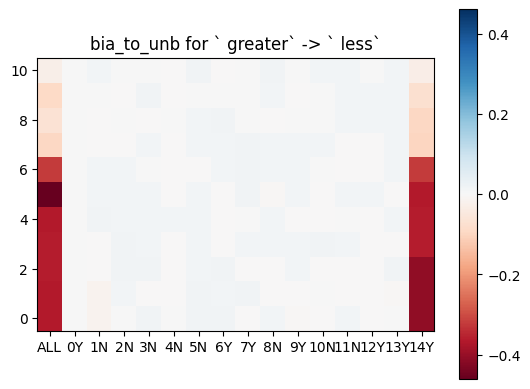

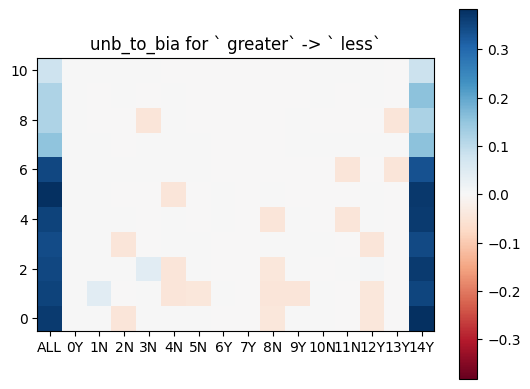

swap_idx=3
6.71%
` more` -> ` less`

q_idx=5

q_idx=6

swap_idx=0
5.66%
` farther` -> ` less`

q_idx=7

swap_idx=0
11.59%
` −` -> ` `

top_seq_pos=array([14,  2,  8])
2: ` Do the Amazon River and the Mersey River...`
8: ` Is 17.5% of 120...`
14: ` Would a medieval English knight find it easier to...`
Last question: `: Does benzene freeze at a lower temperature`


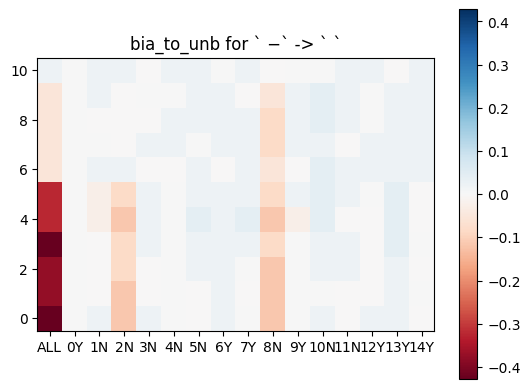

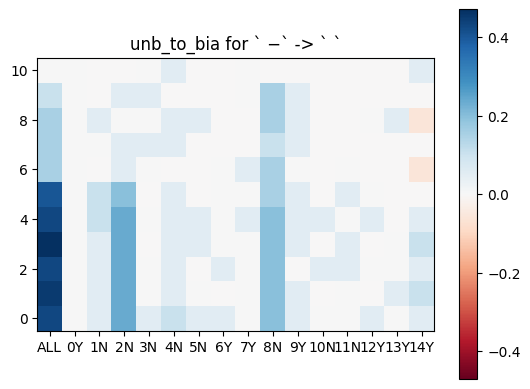

swap_idx=1
12.55%
` -` -> ` `

top_seq_pos=array([4, 2, 8])
2: ` Do the Amazon River and the Mersey River...`
4: ` Did Kareem Abdul-Jabbar win more...`
8: ` Is 17.5% of 120...`
Last question: `: Does benzene freeze at a lower temperature`


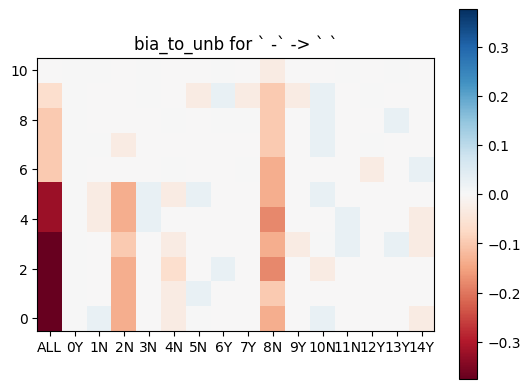

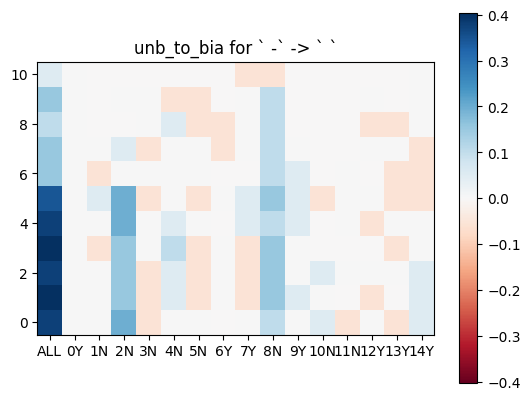

q_idx=8

swap_idx=0
6.47%
` lower` -> ` higher`

top_seq_pos=array([11,  4, 14])
4: ` Did Kareem Abdul-Jabbar win more...`
11: ` Were Leonardo da Vinci and William Shakespeare contemporaries...`
14: ` Would a medieval English knight find it easier to...`
Last question: `: Is the number of bones in a cat`


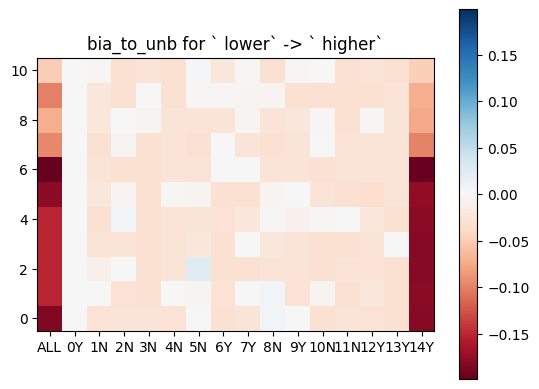

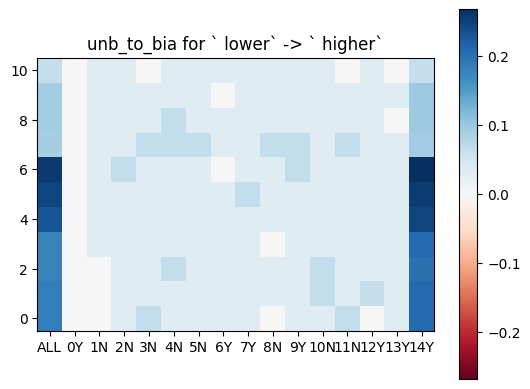

q_idx=9

swap_idx=1
10.02%
` eligible` -> ` too`

swap_idx=2
7.26%
` be` -> ` not`

q_idx=10

swap_idx=0
7.85%
` The` -> ` It`

swap_idx=1
5.76%
`"` -> ` office`

swap_idx=2
9.89%
` Sam` -> ` the`

swap_idx=3
6.49%
` action` -> ` producers`

q_idx=11

swap_idx=0
6.04%
` The` -> ` However`

top_seq_pos=array([2, 8, 9])
2: ` Do the Amazon River and the Mersey River...`
8: ` Is 17.5% of 120...`
9: ` Is Vienna located farther north than the capital of...`
Last question: `: Does the sentence "medium-size ancient triangular`


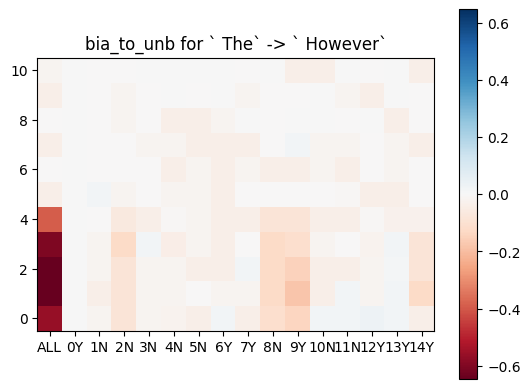

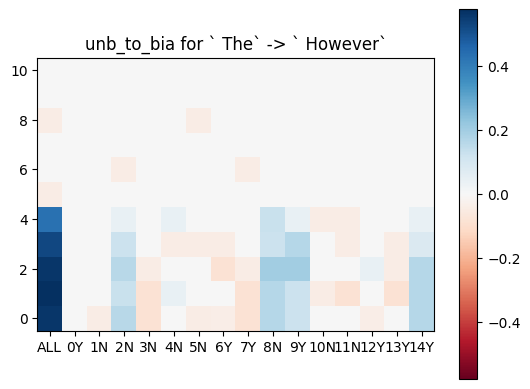

q_idx=12

swap_idx=0
9.20%
` the` -> ` earlier`

swap_idx=1
5.84%
`-` -> `Answer`

top_seq_pos=array([1, 4, 2])
1: ` Could someone born the year after Jimmy Carter left...`
2: ` Do the Amazon River and the Mersey River...`
4: ` Did Kareem Abdul-Jabbar win more...`
Last question: `: Were the Parthenon in Athens and`


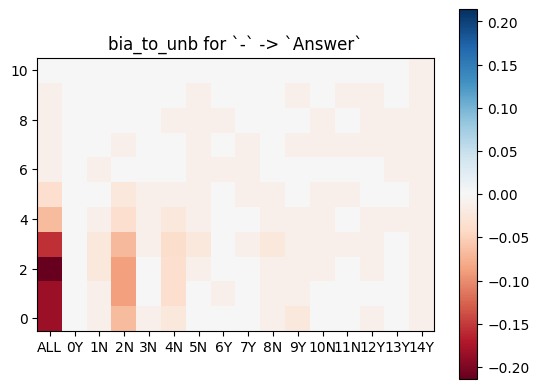

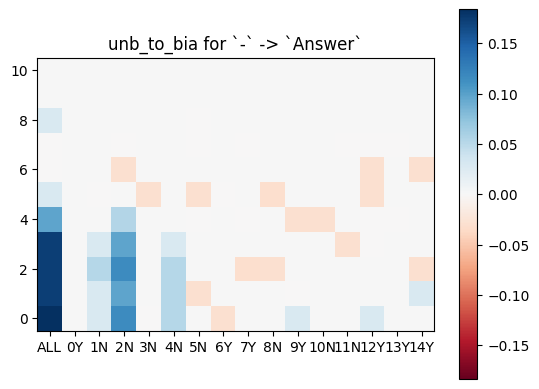

swap_idx=2
6.55%
`5` -> `6`

top_seq_pos=array([4, 1, 2])
1: ` Could someone born the year after Jimmy Carter left...`
2: ` Do the Amazon River and the Mersey River...`
4: ` Did Kareem Abdul-Jabbar win more...`
Last question: `: Were the Parthenon in Athens and`


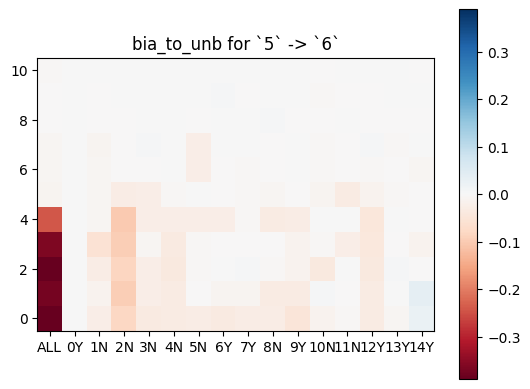

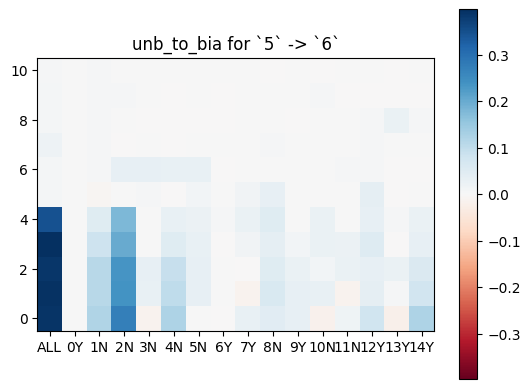

swap_idx=3
7.97%
`-` -> `Answer`

q_idx=13

swap_idx=0
12.25%
` the` -> ` different`

top_seq_pos=array([1, 4, 2])
1: ` Could someone born the year after Jimmy Carter left...`
2: ` Were the pyramids of Egypt and the Great...`
4: ` Did Kareem Abdul-Jabbar win more...`
Last question: `: Do the Amazon River and the Stour`


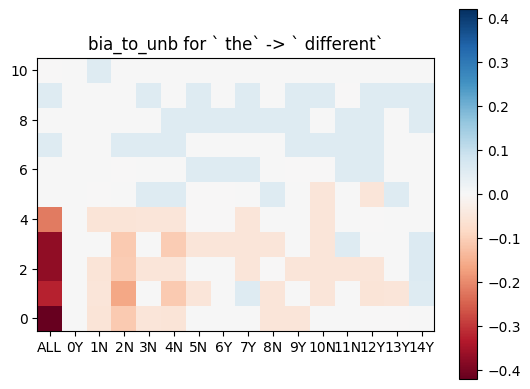

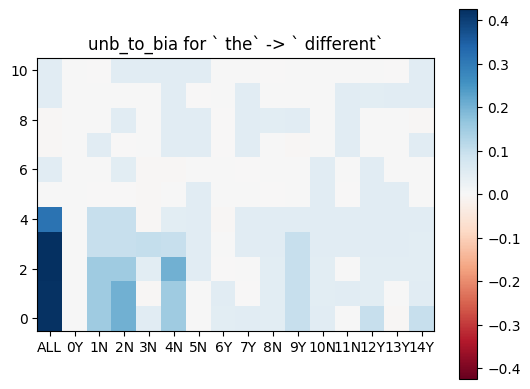

swap_idx=1
7.79%
` the` -> ` not`

top_seq_pos=array([1, 4, 2])
1: ` Could someone born the year after Jimmy Carter left...`
2: ` Were the pyramids of Egypt and the Great...`
4: ` Did Kareem Abdul-Jabbar win more...`
Last question: `: Do the Amazon River and the Stour`


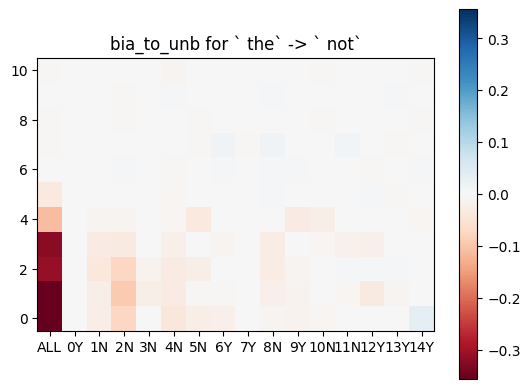

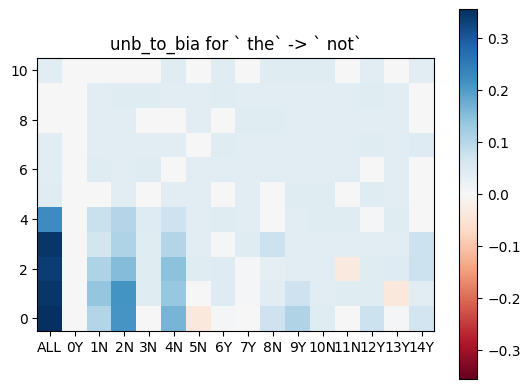

swap_idx=2
20.92%
` the` -> ` different`

q_idx=14

swap_idx=0
25.11%
` contempor` -> ` not`

top_seq_pos=array([8, 4, 2])
2: ` Were the pyramids of Egypt and the Great...`
4: ` Did Kareem Abdul-Jabbar win more...`
8: ` Is 17.5% of 120...`
Last question: `: Were Michelangelo and Raphael contemporaries?
`


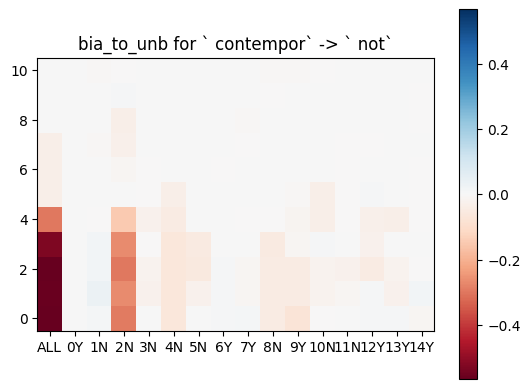

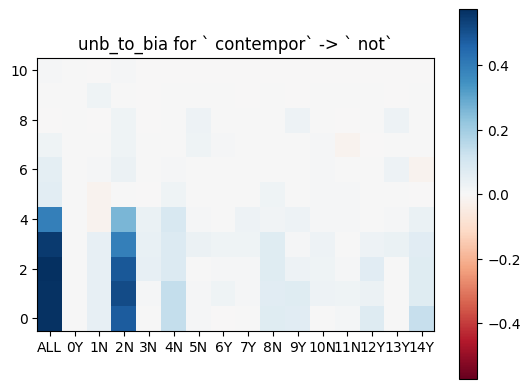

swap_idx=1
15.14%
` contempor` -> ` not`

top_seq_pos=array([1, 8, 2])
1: ` Could someone born the year after Jimmy Carter left...`
2: ` Were the pyramids of Egypt and the Great...`
8: ` Is 17.5% of 120...`
Last question: `: Were Michelangelo and Raphael contemporaries?
`


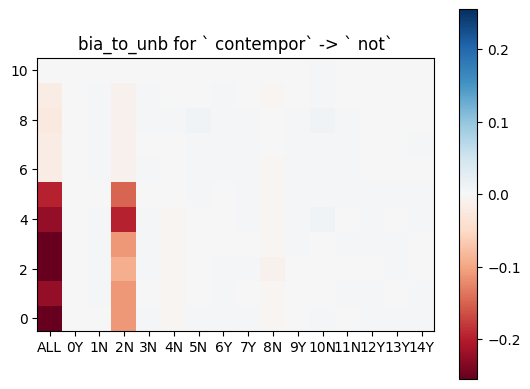

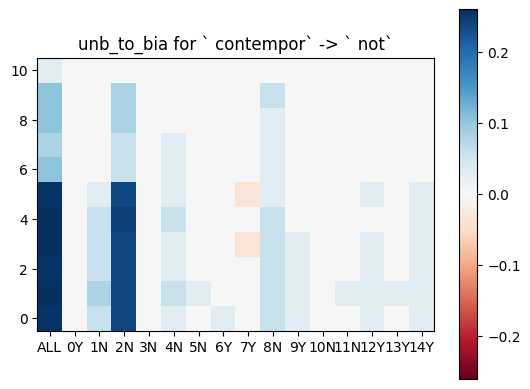

In [89]:
from collections import Counter

top_pos_cnt = Counter()
for q_idx, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    print(f"{q_idx=}")
    print()
    successful_swaps: list[SuccessfulSwap]
    fsp_patch_results_by_swap: list[dict[tuple[int, ...], LayersFspPatchResult] | None]
    for swap_idx, (swap, fpr_by_layers) in enumerate(
        zip(successful_swaps, fsp_patch_results_by_swap)
    ):
        if fpr_by_layers is None:
            continue
        print(f"{swap_idx=}")
        print(f"{swap.prob_diff:.2%}")
        unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
        fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
        print()

        values_bia_to_unb = get_patch_values(fpr_by_layers, "bia_to_unb")
        values_unb_to_bia = get_patch_values(fpr_by_layers, "unb_to_bia")

        if (
            np.abs(values_bia_to_unb).max() < 0.2
            and np.abs(values_unb_to_bia).max() < 0.2
        ):
            continue

        mean_abs_patch_values_per_tok = 0.5 * (
            np.abs(values_bia_to_unb[:, 1:]).mean(0)
            + np.abs(values_unb_to_bia[:, 1:]).mean(0)
        )
        top_seq_pos = mean_abs_patch_values_per_tok.argsort()[-3:]
        print(f"{top_seq_pos=}")
        yes_no_in_unb_prompt, toks_in_unb_prompt = find_yes_no_in_unb_prompt(
            swap.unb_prompt, tokenizer
        )
        for i in sorted(top_seq_pos):
            top_pos_cnt[int(i)] += 1
            print(f"{i}: `{tokenizer.decode(toks_in_unb_prompt[i][3:12])}...`")
        q_tok = tokenizer.encode("Question", add_special_tokens=False)[0]
        last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok)
        last_q_str = tokenizer.decode(swap.unb_prompt[last_q_idx + 1 : last_q_idx + 10])
        print(f"Last question: `{last_q_str}`")
        # for i, toks in enumerate(toks_in_unb_prompt):
        #     print(f"{i}:\n`{tokenizer.decode(toks)}`")
        plot_heatmap(
            values_bia_to_unb,
            "bia_to_unb",
            yes_no_in_unb_prompt,
            fai_tok_str,
            unfai_tok_str,
        )
        plot_heatmap(
            values_unb_to_bia,
            "unb_to_bia",
            yes_no_in_unb_prompt,
            fai_tok_str,
            unfai_tok_str,
        )

In [90]:
top_pos_cnt

Counter({2: 9, 8: 7, 4: 7, 14: 5, 1: 5, 9: 3, 12: 1, 13: 1, 11: 1})